In [ ]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

[Seed 1] Training CartPole-v1


Training CartPole-v1:   0%|          | 0/1000 [00:00<?, ?it/s]

CartPole-v1 Episode 250/1000 - Reward: 50.00
CartPole-v1 Episode 500/1000 - Reward: 376.00
CartPole-v1 Episode 750/1000 - Reward: 336.00
CartPole-v1 Episode 1000/1000 - Reward: 500.00
Finished training CartPole-v1
[Seed 2] Training CartPole-v1


Training CartPole-v1:   0%|          | 0/1000 [00:00<?, ?it/s]

CartPole-v1 Episode 250/1000 - Reward: 170.00
CartPole-v1 Episode 500/1000 - Reward: 360.00
CartPole-v1 Episode 750/1000 - Reward: 500.00
CartPole-v1 Episode 1000/1000 - Reward: 62.00
Finished training CartPole-v1
[Seed 3] Training CartPole-v1


Training CartPole-v1:   0%|          | 0/1000 [00:00<?, ?it/s]

CartPole-v1 Episode 250/1000 - Reward: 43.00
CartPole-v1 Episode 500/1000 - Reward: 287.00
CartPole-v1 Episode 750/1000 - Reward: 365.00
CartPole-v1 Episode 1000/1000 - Reward: 500.00
Finished training CartPole-v1
Saved reward arrays for CartPole-v1


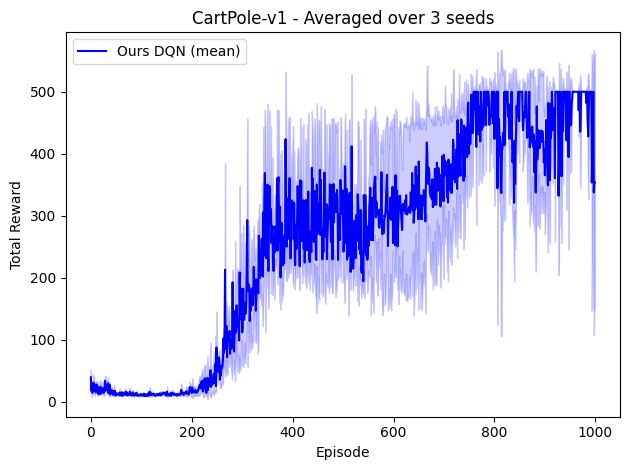

In [ ]:

import random
import numpy as np
np.float_ = np.float64
np.bool8 = np.bool_

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import gymnasium as gym_sb3
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.auto import tqdm
from collections import deque, namedtuple
from IPython.display import HTML, display
from stable_baselines3 import DQN as SB3_DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super().__init__()
        torch.manual_seed(seed)
        self.net = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, action_size)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity, batch_size, seed):
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", ["s", "a", "r", "s2", "d"])
        random.seed(seed)

    def add(self, s, a, r, s2, d):
        self.memory.append(self.experience(s, a, r, s2, d))

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states = torch.tensor([e.s for e in batch], dtype=torch.float32, device=DEVICE)
        actions = torch.tensor([e.a for e in batch], dtype=torch.int64, device=DEVICE).unsqueeze(-1)
        rewards = torch.tensor([e.r for e in batch], dtype=torch.float32, device=DEVICE).unsqueeze(-1)
        next_states = torch.tensor([e.s2 for e in batch], dtype=torch.float32, device=DEVICE)
        dones = torch.tensor([float(e.d) for e in batch], dtype=torch.float32, device=DEVICE).unsqueeze(-1)
        return states, actions, rewards, next_states, dones

    def __len__(self): return len(self.memory)

class DQNAgent:
    def __init__(self, state_size, action_size, seed, lr, buffer_size, batch_size, gamma, tau, update_every):
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every
        self.local = QNetwork(state_size, action_size, seed).to(DEVICE)
        self.target = QNetwork(state_size, action_size, seed).to(DEVICE)
        self.target.load_state_dict(self.local.state_dict())
        self.optimizer = optim.Adam(self.local.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        self.batch_size = batch_size
        self.t_step = 0

    def act(self, state, eps):
        if random.random() < eps:
            return random.randrange(self.action_size)
        st = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        self.local.eval()
        with torch.no_grad():
            qv = self.local(st)
        self.local.train()
        return int(qv.argmax(dim=1).item())

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(*experiences)

    def learn(self, states, actions, rewards, next_states, dones):
        with torch.no_grad():
            q_next = self.target(next_states).max(1, keepdim=True)[0]
            q_target = rewards + self.gamma * q_next * (1 - dones)
        q_expected = self.local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        for lp, tp in zip(self.local.parameters(), self.target.parameters()):
            tp.data.copy_(self.tau * lp.data + (1 - self.tau) * tp.data)

class EpisodeRewardLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rewards = []
    def _on_step(self) -> bool:
        for info in self.locals.get("infos", []):
            if "episode" in info:
                self.rewards.append(info["episode"]["r"])
        return True

def train_custom_dqn(env_id, config, seed):
    set_global_seed(seed)
    eps0, batch, gamma, lr, buf, upd, eps_start, eps_end, eps_decay, tau, episodes = config
    env = gym.make(env_id)
    if env_id == "MountainCar-v0":
        env._max_episode_steps = 1000
    env.seed(seed)
    env.action_space.seed(seed)
    s_dim = env.observation_space.shape[0]
    a_dim = env.action_space.n
    agent = DQNAgent(s_dim, a_dim, seed, lr, buf, batch, gamma, tau, upd)
    returns = []
    for ep in tqdm(range(1, episodes + 1), desc=f"Training {env_id}"):
        eps = max(eps_end, eps_start * (eps_decay ** (ep - 1)))
        out = env.reset()
        state = out[0] if isinstance(out, tuple) else out
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            step = env.step(action)
            if len(step) == 5:
                next_s, r, term, trunc, _ = step
                done = term or trunc
            else:
                next_s, r, done, _ = step
            agent.step(state, action, r, next_s, done)
            total_reward += r
            state = next_s
        returns.append(total_reward)
        if ep % (250) == 0: #episodes//5
          print(f"{env_id} Episode {ep}/{episodes} - Reward: {total_reward:.2f}")
    env.close()
    print(f"Finished training {env_id}")
    return returns

def train_sb3_dqn(env_id, seed, lr, buf, tau_, learn_start, batch, tr_freq, grad_steps, targ_upd_int, gamma_, expl_frac, eps_start, eps_end, episodes):
    env0 = gym_sb3.make(env_id)
    env_sb3 = Monitor(env0)
    env_sb3.reset(seed=seed)
    env_sb3.action_space.seed(seed)
    if env_id == "MountainCar-v0":
        env0._max_episode_steps = 1000
    max_steps = getattr(env_sb3.env, "_max_episode_steps", env_sb3.env.spec.max_episode_steps)
    total_timesteps = episodes * max_steps
    model = SB3_DQN(
        "MlpPolicy", env_sb3,
        seed=seed,
        device=DEVICE,
        learning_rate=lr,
        buffer_size=buf,
        tau=tau_,
        learning_starts=learn_start,
        batch_size=batch,
        train_freq=tr_freq,
        gradient_steps=grad_steps,
        target_update_interval=targ_upd_int,
        gamma=gamma_,
        exploration_fraction=expl_frac,
        exploration_initial_eps=eps_start,
        exploration_final_eps=eps_end,
        verbose=0
    )
    logger = EpisodeRewardLogger()
    model.learn(total_timesteps=total_timesteps, callback=logger)
    return logger.rewards[:episodes]

def run_multiple_seeds(env_id, cfg, seeds):#def run_multiple_seeds(env_id, cfg, sb3_params, seeds):

    all_returns_custom = []
    #all_returns_sb3 = []

    for seed in seeds:
        print(f"[Seed {seed}] Training {env_id}")
        returns_custom = train_custom_dqn(env_id, cfg, seed)
        #returns_sb3 = train_sb3_dqn(env_id, seed, *sb3_params)

        all_returns_custom.append(returns_custom)
        #all_returns_sb3.append(returns_sb3)

    # Convert and save
    all_returns_custom = np.array(all_returns_custom, dtype=np.float32)
    #all_returns_sb3 = np.array(all_returns_sb3, dtype=np.float32)

    np.save(f"{env_id}_custom_dqn_rewards.npy", all_returns_custom)
    #np.save(f"{env_id}_sb3_dqn_rewards.npy", all_returns_sb3)
    print(f"Saved reward arrays for {env_id}")

    # Plotting
    mean_custom = np.mean(all_returns_custom, axis=0)
    std_custom = np.std(all_returns_custom, axis=0)
    #mean_sb3 = np.mean(all_returns_sb3, axis=0)
    #std_sb3 = np.std(all_returns_sb3, axis=0)
    x = np.arange(mean_custom.shape[0])
    plt.figure()
    plt.plot(x, mean_custom, label="Ours DQN (mean)", color="blue")
    plt.fill_between(x, mean_custom - std_custom, mean_custom + std_custom, alpha=0.2, color="blue")
    #plt.plot(x, mean_sb3, label="SB3 DQN (mean)", color="green")
    #plt.fill_between(x, mean_sb3 - std_sb3, mean_sb3 + std_sb3, alpha=0.2, color="green")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"{env_id} - Averaged over {len(seeds)} seeds")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{env_id}_reward_plot.png")
    plt.show()

if __name__ == '__main__':
    seeds = [1, 2, 3]
    configs = {
        # "CartPole-v1":    (1.0, 64, 0.99, 5e-4, 10_000, 4, 1.0, 0.1, 0.995, 0.2, 600),
        # "MountainCar-v0": (1.0, 64, 0.99, 1e-3, 50_000, 10, 1.0, 0.01, 0.995, 1, 2000),
        # "Acrobot-v1":     (1.0, 64, 0.99, 5e-4, 20_000, 1, 1.0, 0.02, 0.995, 0.1, 600),
        "CartPole-v1":    (1.0, 64, 0.99, 3e-4, 20_000, 4, 1.0, 0.1, 0.99, 0.01, 1000),


    }
    # sb3_params = {
    #     "CartPole-v1":     (1e-3, 10_000, 0.4, 1000, 64, 4, 1, 100, 0.99, 0.05, 1.0, 0.1, 10),
    #     "MountainCar-v0":  (1e-3, 10_000, 0.05, 1000, 64, 1, 1, 250, 0.99, 0.1, 1.0, 0.01, 10),
    #     "Acrobot-v1":      (3e-4, 50_000, 0.6, 2000, 64, 1, 1, 300, 0.99, 0.3, 1.0, 0.1, 10),
    # }

    for env_id in configs:
        run_multiple_seeds(env_id, configs[env_id], seeds)#        run_multiple_seeds(env_id, configs[env_id], sb3_params[env_id], seeds)



In [ ]:
from google.colab import files
files.download("CartPole-v1_custom_dqn_rewards.npy")
files.download("MountainCar-v0_custom_dqn_rewards.npy")
files.download("Acrobot-v1_custom_dqn_rewards.npy")

FileNotFoundError: Cannot find file: CartPole-v111111_custom_dqn_rewards.npy

In [2]:
open("MountainCar-v0_custom_dqn_rewards.npy")
plt.plot(load("MountainCar-v0_custom_dqn_rewards.npy"))

FileNotFoundError: [Errno 2] No such file or directory: 'MountainCar-v0_custom_dqn_rewards.npy'